In [10]:
import torch
from torch import nn

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, h_dim=200, z_dim=20):
        super().__init__()
        self.img2h = nn.Linear(input_dim, h_dim) # input img --> hidden_dim --> mean, std --> reparameterization trick --> decoder --> output img

        # loss pushes these to be a standard Gaussian to ensure that latent space is standard Gaussian, while still using a reconstruction loss
        self.h2mu = nn.Linear(h_dim, z_dim) 
        self.h2sigma = nn.Linear(h_dim, z_dim)

        self.z2h = nn.Linear(z_dim, h_dim)
        self.h2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    
    def encode(self, x):
        # q_phi(z|x)

        h = self.img2h(x)
        h = self.relu(h)
        mu, sigma = self.h2mu(h), self.h2sigma(h)

        return mu, sigma
    
    def decode(self, z):
        # p_theta(x|z)

        h = self.relu(self.z2h(z))
        x = self.h2img(h)

        return torch.sigmoid(x)
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_reparam = mu + sigma * sigma * epsilon
        x = self.decode(z_reparam)

        return x, mu, sigma

In [9]:
x = torch.randn(4, 28 * 28) # 28 ** 2 = 784
vae = VAE()
x_pred, mu, sigma = vae(x)
print(x_pred.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


In [16]:
import torch.optim as optim # all optimization algorithms like SGD, Adam
import torch.nn.functional as F # all functions that don't have parameters (activation functions, tanh), also included in nn
from torch.utils.data import DataLoader 
import torchvision.datasets as datasets # import pytorch datasets
import torchvision.transforms as transforms # transformations on dataset
from tqdm import tqdm

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 784
h_dim = 200
z_dim = 20
num_epochs = 10
batch_size = 32
lr = 3e-4

In [19]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
model = VAE(input_dim=input_dim, h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction="sum") # BCE

In [27]:
for epoch in range(num_epochs):
    pbar = tqdm(enumerate(train_loader))
    for i, (images, _) in tqdm(enumerate(train_loader)):
        images = images.to(device).view(batch_size, -1)
        preds, mu, sigma = model(images)

        reconstruction_loss = criterion(preds, images)
        kl_div = torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        kl_div = kl_div * -1
        loss = kl_div + reconstruction_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.4f}")



0it [00:12, ?it/s]
1875it [00:18, 99.83it/s]0:18, ?it/s] 
Loss: 4617.8198: : 0it [00:18, ?it/s]
1875it [00:23, 79.07it/s]
Loss: 3796.1245: : 0it [00:23, ?it/s]
1875it [00:18, 101.63it/s]:18, ?it/s]
Loss: 3972.2190: : 0it [00:18, ?it/s]
1875it [00:22, 84.45it/s]
Loss: 3706.0361: : 0it [00:22, ?it/s]
1875it [00:18, 102.61it/s]:18, ?it/s]
Loss: 3937.4780: : 0it [00:18, ?it/s]
1875it [00:22, 83.99it/s]
Loss: 3704.7131: : 0it [00:22, ?it/s]
1875it [00:18, 102.33it/s]:18, ?it/s]
Loss: 3455.9973: : 0it [00:18, ?it/s]
1875it [00:22, 82.95it/s]
Loss: 3312.4927: : 0it [00:22, ?it/s]
1875it [00:18, 101.96it/s]:18, ?it/s]
Loss: 3530.2710: : 0it [00:18, ?it/s]
1875it [00:22, 82.11it/s]


In [31]:
images = []
idx = 0
for x, y in dataset:
    if y == idx:
        idx += 1
        images.append(x)
    if idx == 10:
        break

In [36]:
def inference(digit, num_examples=1):
    mu, sigma = model.encode(images[digit].view(-1, 784))
    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    print(z.shape)
    out = model.decode(z).view(-1, 1, 28, 28)
    matplotlib.imshow(out)


In [42]:
import matplotlib.pyplot as plt

def inference(digit, num_examples=1):
    mu, sigma = model.encode(images[digit].view(-1, 784))
    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    out = model.decode(z).view(-1, 1, 28, 28)

    plt.imshow(out[0].detach().cpu().numpy().reshape(28, 28), cmap='gray')
    plt.title(f"Generated Digit: {digit}")
    plt.show()


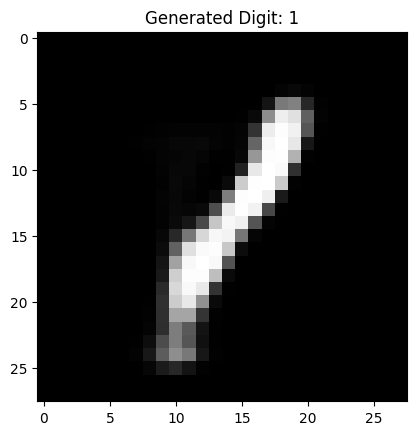

In [43]:
inference(1)